In [217]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import copy


In [218]:
# Reads data from csv file
label_encoder = LabelEncoder()
data = pd.read_csv('data/market_analysis.csv', delimiter=';')

data['month'] = pd.to_datetime(data['month'], format='%Y-%m')
data['revenue'] = data['revenue'].str.replace(',', '.').astype(float)

# Assuming 'guests' column might also contain '15+' or similar strings
data['guests'] = data['guests'].replace('15+', 15).astype(float)

# Encode 'city' column
data['city_encoded'] = label_encoder.fit_transform(data['city'])

# Calculate MonthSin and MonthCos
data['MonthSin'] = np.sin(2 * np.pi * data['month'].dt.month / 12)
data['MonthCos'] = np.cos(2 * np.pi * data['month'].dt.month / 12)

# Select features and target before removing NaN values
cleaned_data = data[['bedrooms', 'bathrooms', 'guests', 'city_encoded', 'MonthSin', 'MonthCos']]
actual_rev = data['revenue'].copy()

# Remove rows with NaN values from both features and target
combined = cleaned_data.copy()
combined['revenue'] = actual_rev
combined_clean = combined.dropna()

# Separate features and target again after cleaning
cleaned_data = combined_clean[['bedrooms', 'bathrooms', 'guests', 'city_encoded', 'MonthSin', 'MonthCos']]
actual_rev = combined_clean['revenue']
combined_clean = combined_clean[combined_clean['revenue'] != 0]
split_index = int(len(combined_clean) * 0.8)
train = combined_clean.iloc[:split_index]
test = combined_clean.iloc[split_index:]
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_data, actual_rev, test_size=0.2, random_state=42)

In [219]:
# Now, fit the model
model = KNeighborsRegressor(n_neighbors=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = model.predict(X_test)
KNNmae = mean_absolute_error(y_test, y_pred)
KNNmse = mean_squared_error(y_test, y_pred)
KNNr2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {KNNmae}")
print(f"Mean Squared Error: {KNNmse}")
print(f"R-squared: {KNNr2}")

Mean Absolute Error: 4189.089332116154
Mean Squared Error: 42718439.47102543
R-squared: 0.21479857248959056


In [221]:
#Optimize GMM components
def gmm_bic_score(estimator, X, Y):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    
    return -estimator.bic(X)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)
# param_grid = {
#     'n_components' : range(80, 81),
#     "covariance_type": ["tied", "diag", "full"],
#     }
# grid_search = GridSearchCV(
#     GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
# )
# grid_search.fit(X_train, y_train)
df = pd.DataFrame(columns=["Number of Components", "Covariance Type", "BIC Score"])
n_components = range(1, 40)
cov_types = ["full", "diag"]
rows = []
for i in n_components:
    for j in cov_types:
        gmm = GaussianMixture(n_components=i, covariance_type=j, random_state=42)
        gmm.fit(train)
        bic = gmm.bic(train)
        aic = gmm.aic(train)
        label = gmm.predict(test)
        means = gmm.means_
        preds = means[label]
        pred = preds[:,-1]
        GMMmae = mean_absolute_error(test['revenue'], pred)
        GMMmse = mean_squared_error(test['revenue'], pred)
        GMMr2 = r2_score(test['revenue'], pred)
        new_row = {
            "Number of Components": i,
            "Covariance Type": j,
            "BIC Score": bic,
            "AIC Score": aic,
            "MSE": GMMmse,
            "MAE": GMMmae,
            "R2": GMMr2
        }
        rows.append(new_row)
df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)




C:\Users\wfjoh\AppData\Local\Temp\ipykernel_89140\1938835013.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)


c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


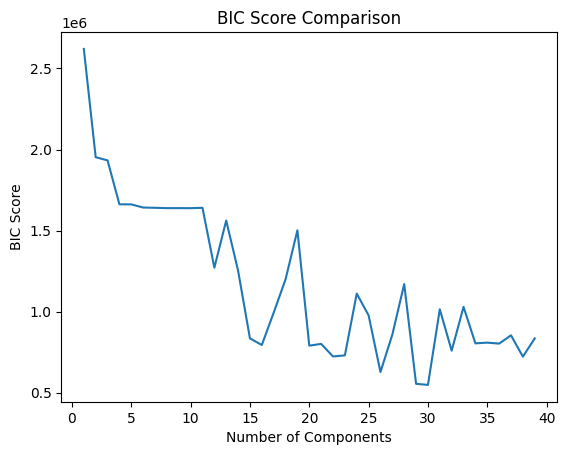

C:\Users\wfjoh\AppData\Local\Temp\ipykernel_89140\1516350655.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Number of Components", y="AIC-BIC Difference", ci=None)
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


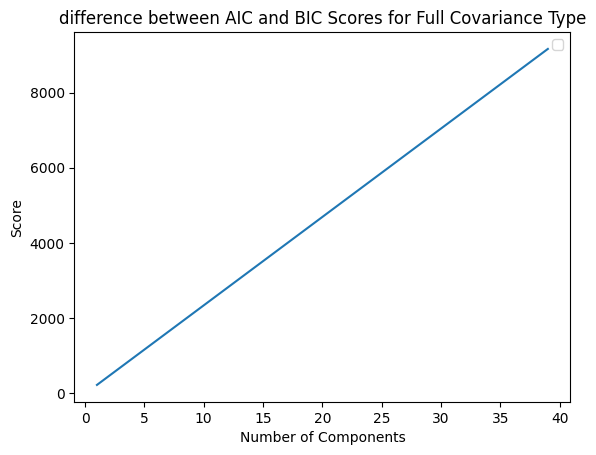

c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: Whe

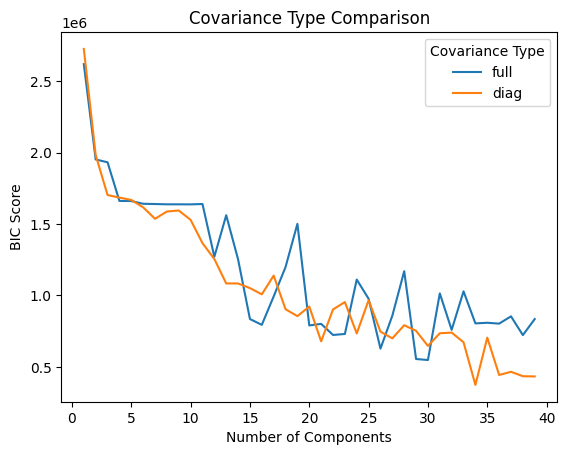

c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


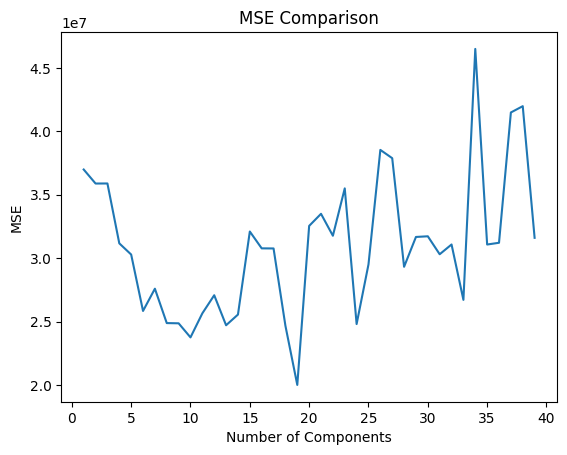

c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


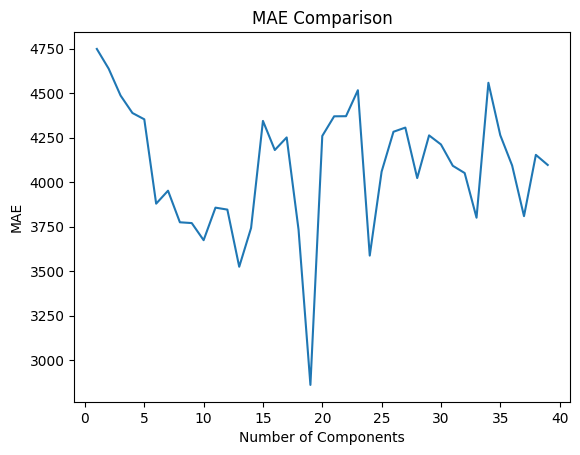

c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wfjoh\anaconda3\envs\MLClasswork\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


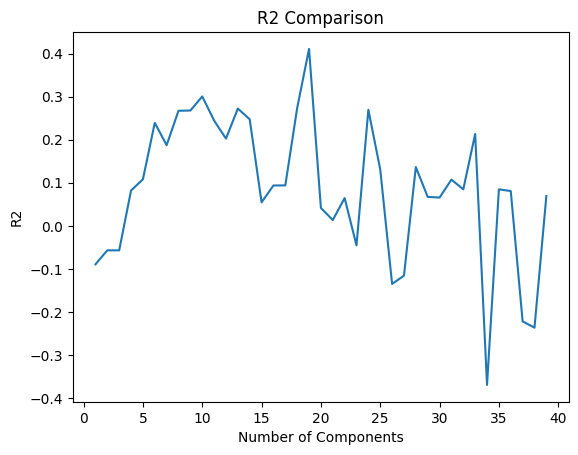

In [225]:
#Plot Full Cov Type BIC over num components
sns.lineplot(
    data=df.where(df["Covariance Type"] == "full"),
    x="Number of Components",
    y="BIC Score",
)

plt.title("BIC Score Comparison")
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.show()

df["AIC-BIC Difference"] = df["BIC Score"]-df["AIC Score"]
sns.lineplot(data=df, x="Number of Components", y="AIC-BIC Difference", ci=None)

plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("difference between AIC and BIC Scores for Full Covariance Type")
plt.legend()  # Display the legend to differentiate between AIC and BIC
plt.show()

# plt.title("AIC Score Comparison")
# plt.xlabel("Number of Components")
# plt.ylabel("AIC Score")
# plt.show()

#Plot cov comparison
sns.lineplot(
    data=df,
    x="Number of Components",
    y="BIC Score",
    hue="Covariance Type",
)

plt.title("Covariance Type Comparison")
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.show()

#Plot MSE vs num components
sns.lineplot(
    data=df.where(df["Covariance Type"] == "full"),
    x="Number of Components",
    y="MSE",
)

plt.title("MSE Comparison")
plt.xlabel("Number of Components")
plt.ylabel("MSE")
plt.show()

#Plot MAE vs num components
sns.lineplot(
    data=df.where(df["Covariance Type"] == "full"),
    x="Number of Components",
    y="MAE",
)

plt.title("MAE Comparison")
plt.xlabel("Number of Components")
plt.ylabel("MAE")
plt.show()

#Plot R2 vs num components
sns.lineplot(
    data=df.where(df["Covariance Type"] == "full"),
    x="Number of Components",
    y="R2",
)

plt.title("R2 Comparison")
plt.xlabel("Number of Components")
plt.ylabel("R2")
plt.show()

In [227]:
#Use the elbow method to pick out an ideal value for components
#Use full cov type

gmm = GaussianMixture(n_components=19, covariance_type="full")
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
gmm.fit(train)
label = gmm.predict(test)
means = gmm.means_
preds = means[label]
pred = preds[:,-1]
GMMmae = mean_absolute_error(test['revenue'], pred)
GMMmse = mean_squared_error(test['revenue'], pred)
GMMr2 = r2_score(test['revenue'], pred)

print(f"Mean Absolute Error: {GMMmae}")
print(f"Mean Squared Error: {GMMmse}")
print(f"R-squared: {GMMr2}")


Mean Absolute Error: 4104.826289561264
Mean Squared Error: 31822861.170102865
R-squared: 0.06266092455250905


In [ ]:
categories = ['KNN', 'GMM']
values = [KNNmae, GMMmae]

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Mean Absolute Error')

plt.show()

In [ ]:
categories = ['KNN', 'GMM']
values = [KNNmse, GMMmse]

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Mean Squared Error')

plt.show()

In [ ]:
categories = ['KNN', 'GMM']
values = [KNNr2, GMMr2]

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('R-Squared')

plt.show()

In [ ]:
data = [
    ["Category", "KNN", "GMM"],
    ["Mean Absolute Error", 2800.576927073185, 2382.586097586939],
    ["Mean Squared Error", 18655650.20528432, 10706274.05793304],
    ["R-Squared", 0.2684389834391159, 0.3785225626252957]
]

print(tabulate(data, headers="firstrow"))

In [ ]:

sorted_test = test.sort_values(by="revenue", ascending=False)
label = gmm.predict(sorted_test)
means = gmm.means_
preds = means[label]
pred=preds[:,-1]
test_mse = mean_absolute_error(sorted_test['revenue'][0:5], pred[0:5])
print(sorted_test[0:5])
print(f"MSE For Top 5 Revenues: {test_mse}")
print("\n")

mse = mean_squared_error(sorted_test['revenue'][0:5], pred[0:5])
r2 = r2_score(sorted_test['revenue'][0:5], pred[0:5])
sorted_test = test.sort_values(by="revenue", ascending=True)
label = gmm.predict(sorted_test)
means = gmm.means_
preds = means[label]
pred=preds[:,-1]
test_mse = mean_absolute_error(sorted_test['revenue'][0:5], pred[0:5])
mse = mean_squared_error(sorted_test['revenue'][0:5], pred[0:5])
r2 = r2_score(sorted_test['revenue'][0:5], pred[0:5])
print(sorted_test[0:5])
print("\n")
print(f"MSE For Bottom 5 Revenues: {test_mse}")
